# Football players tracking with YOLOv5 + ByteTrack

## About

In this tutorial, we will utilize an open source computer vision dataset from one of the 100,000+ available on [Roboflow Universe](https://universe.roboflow.com/).

If you already have your own images (and, optionally, annotations), you can convert your dataset using Roboflow, a set of tools developers use to build better computer vision models quickly and accurately. 150k+ developers use roboflow for (automatic) annotation, converting dataset formats (like to YOLOv5), training, deploying, and improving their datasets/models.

**Usefull links:**

- [YOLOv5 repository](https://github.com/ultralytics/yolov5)
- [ByteTrack repository](https://github.com/ifzhang/ByteTrack)
- [Roboflow Notebooks](https://github.com/roboflow-ai/notebooks)

## Table of content:
* [Setup](#setup)
* [Download data](#download-data)
* [Install YOLOv5](#install-yolov5)
* [Install ByteTrack and other libs](#install-bytetrack)
* [Custom annotator](#custom-annotator)
* [Detect ball possession](#detect-ball-possession)
* [Full video tracking](#full-video-tracking)
* [Put everything together](#put-everything-together)




## Setup <a class="anchor" id="setup"></a>

In [5]:
!nvidia-smi

Wed Dec 27 15:24:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
import cv2
import numpy as np
from sklearn.cluster import KMeans


def get_dominant_color(image, k=1):
    # Convert image to RGB (OpenCV uses BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(image)
    dominant_color = kmeans.cluster_centers_[0].astype(int)
    return dominant_color

# Usage example: dominant_color = get_dominant_color(player_image)


In [7]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download data <a class="anchor" id="download-data"></a>

In [8]:
!pip install kaggle --upgrade --quiet

We will use [DFL - Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout/data) from Kaggle. We can download it using [Kaggle API](https://github.com/Kaggle/kaggle-api). According to documentation we need to set up two environment variables first:

```
export KAGGLE_USERNAME=datadinosaur
export KAGGLE_KEY=xxxxxxxxxxxxxx
```

In [9]:
import os
from getpass import getpass

In [23]:
os.environ['KAGGLE_USERNAME'] = getpass('Enter KAGGLE_USERNAME secret value: ')
os.environ['KAGGLE_KEY'] = getpass('Enter KAGGLE_KEY secret value: ')

Enter KAGGLE_USERNAME secret value: ··········
Enter KAGGLE_KEY secret value: ··········


In [24]:
!kaggle competitions files -c dfl-bundesliga-data-shootout | grep clips | head -10

clips/08fd33_2.mp4      21MB  2022-07-29 14:23:09  
clips/08fd33_9.mp4      18MB  2022-07-29 14:23:09  
clips/0a2d9b_9.mp4      18MB  2022-07-29 14:23:09  
clips/08fd33_3.mp4      17MB  2022-07-29 14:23:09  
clips/08fd33_6.mp4      19MB  2022-07-29 14:23:09  
clips/08fd33_0.mp4      19MB  2022-07-29 14:23:09  
clips/0a2d9b_5.mp4      18MB  2022-07-29 14:23:09  
clips/08fd33_7.mp4      18MB  2022-07-29 14:23:09  
clips/0a2d9b_0.mp4      20MB  2022-07-29 14:23:09  
clips/0a2d9b_7.mp4      19MB  2022-07-29 14:23:09  


In [25]:
%cd {HOME}
!kaggle competitions files -c dfl-bundesliga-data-shootout | \
grep clips | head -20 | \
awk '{print $1}' | \
while read -r line; \
  do kaggle competitions download -c dfl-bundesliga-data-shootout -f $line -p clips --quiet; \
  unzip ${line}.zip -d clips && rm ${line}.zip; \
  done

/content
Archive:  clips/08fd33_2.mp4.zip
  inflating: clips/08fd33_2.mp4      
Archive:  clips/08fd33_9.mp4.zip
  inflating: clips/08fd33_9.mp4      
Archive:  clips/0a2d9b_9.mp4.zip
  inflating: clips/0a2d9b_9.mp4      
Archive:  clips/08fd33_3.mp4.zip
  inflating: clips/08fd33_3.mp4      
Archive:  clips/08fd33_6.mp4.zip
  inflating: clips/08fd33_6.mp4      
Archive:  clips/08fd33_0.mp4.zip
  inflating: clips/08fd33_0.mp4      
Archive:  clips/0a2d9b_5.mp4.zip
  inflating: clips/0a2d9b_5.mp4      
Archive:  clips/08fd33_7.mp4.zip
  inflating: clips/08fd33_7.mp4      
Archive:  clips/0a2d9b_0.mp4.zip
  inflating: clips/0a2d9b_0.mp4      
Archive:  clips/0a2d9b_7.mp4.zip
  inflating: clips/0a2d9b_7.mp4      
Archive:  clips/08fd33_1.mp4.zip
  inflating: clips/08fd33_1.mp4      
Archive:  clips/0a2d9b_2.mp4.zip
  inflating: clips/0a2d9b_2.mp4      
Archive:  clips/0a2d9b_1.mp4.zip
  inflating: clips/0a2d9b_1.mp4      
Archive:  clips/08fd33_4.mp4.zip
  inflating: clips/08fd33_4.mp4    

## Install YOLOv5 <a class="anchor" id="install-yolov5"></a>

In [26]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-254-gba63208 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 27.1/166.8 GB disk)


### Use pre-trained COCO model - full video

In [27]:
%cd {HOME}/yolov5
!python detect.py --weights yolov5x.pt --img 640 --conf 0.25 --source {HOME}/clips/08fd33_4.mp4 --name coco

/content/yolov5
detect: weights=['yolov5x.pt'], source=/content/clips/08fd33_4.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=coco, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-254-gba63208 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
video 1/1 (1/750) /content/clips/08fd33_4.mp4: 384x640 25 persons, 1 sports ball, 65.9ms
video 1/1 (2/750) /content/clips/08fd33_4.mp4: 384x640 25 persons, 1 sports ball, 57.1ms
video 1/1 (3/750) /content/clips/08fd33_4.mp4: 384x640 26 persons, 1 sports ball, 57.1ms
video 1/1 (4

In [28]:
# %cd {HOME}/yolov5
# !python detect.py --weights yolov5x6.pt --img 1280 --conf 0.25 --source {HOME}/clips/08fd33_4.mp4 --name coco

### Use custom model - full video

This model was traind using [football-players-detection](https://app.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/overview) dataset.

In [29]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I" -O best.pt && rm -rf /tmp/cookies.txt

/content
--2023-12-27 15:27:49--  https://docs.google.com/uc?export=download&confirm=t&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I
Resolving docs.google.com (docs.google.com)... 173.194.211.101, 173.194.211.100, 173.194.211.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.211.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lnq0k769v282qffa674dqmn861o1h83e/1703690850000/04309230031174164349/*/1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I?e=download&uuid=1bb4d5ea-1a65-4691-98c9-8c6fe8b0b697 [following]
--2023-12-27 15:27:49--  https://doc-0g-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lnq0k769v282qffa674dqmn861o1h83e/1703690850000/04309230031174164349/*/1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I?e=download&uuid=1bb4d5ea-1a65-4691-98c9-8c6fe8b0b697
Resolving doc-0g-ag-docs.googleusercontent.com (doc-0g-ag-docs.googleusercontent.com)... 74.

In [30]:
WEIGHTS_PATH = f"{HOME}/best.pt"

In [31]:
%cd {HOME}/yolov5
!python detect.py --weights {HOME}/best.pt --img 1280 --conf 0.25 --source {HOME}/clips/08fd33_4.mp4 --name custom

/content/yolov5
detect: weights=['/content/best.pt'], source=/content/clips/08fd33_4.mp4, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=custom, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-254-gba63208 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 416 layers, 139999708 parameters, 0 gradients, 207.9 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
video 1/1 (1/750) /content/clips/08fd33_4.mp4: 768x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 119.7ms
video 1/1 (2/750) /content/clips/08fd33_4.mp4: 768x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 112.0ms
video 1/1 (3/750) /content/clips/08fd33_4.mp4: 768

### Use custom model - single frame

In [32]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.imshow(image[...,::-1])
    plt.show()

In [33]:
SOURCE_VIDEO_PATH = f"{HOME}/clips/08fd33_4.mp4"

In [34]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

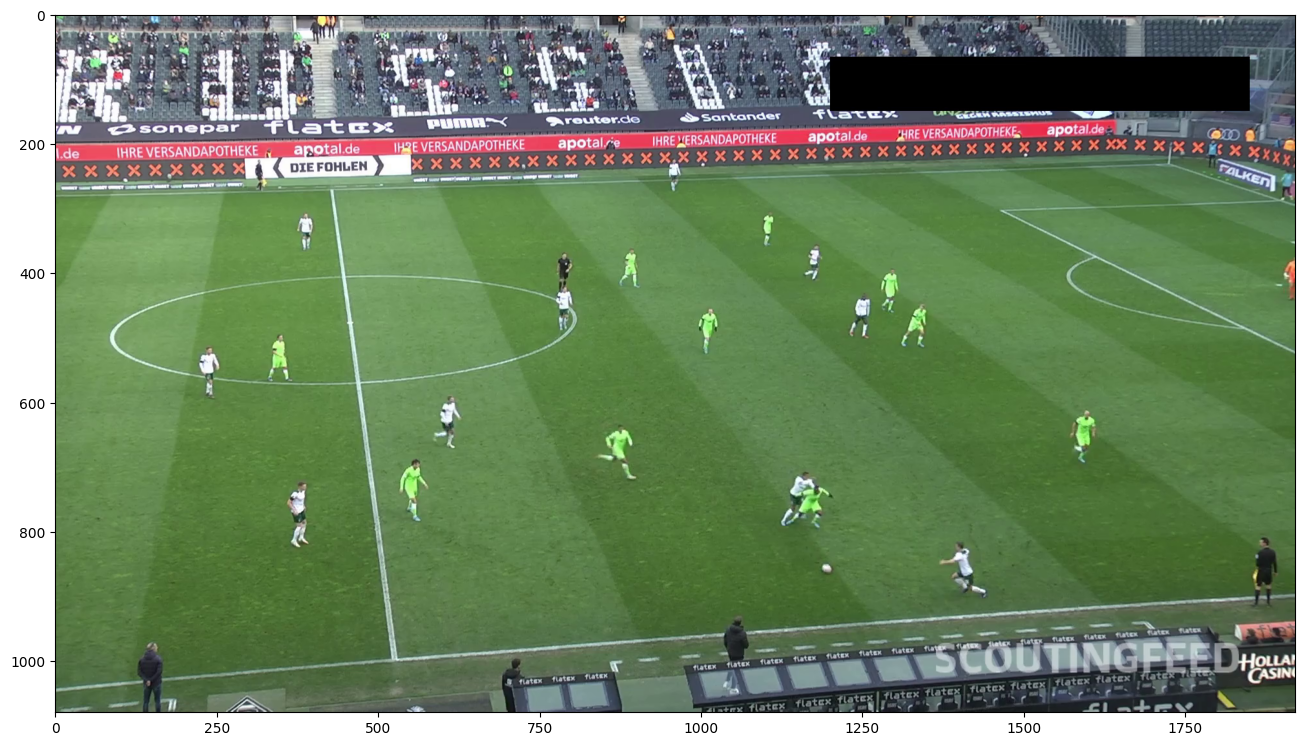

In [35]:
frame = next(frame_iterator)
plot_image(frame, 16)

In [36]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'custom', WEIGHTS_PATH, device=0)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-254-gba63208 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 416 layers, 139999708 parameters, 0 gradients, 207.9 GFLOPs
Adding AutoShape... 


In [37]:
results = model(frame, size=1280)

In [38]:
results.pandas()

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 1080x1920 1 ball, 1 goalkeeper, 19 players, 3 referees
Speed: 11.9ms pre-process, 191.0ms inference, 487.0ms NMS per image at shape (1, 3, 768, 1280)

In [39]:
results.pred[0]

tensor([[5.33234e+02, 6.87570e+02, 5.78573e+02, 7.84712e+02, 9.73769e-01, 2.00000e+00],
        [3.27560e+02, 4.94221e+02, 3.67715e+02, 5.70054e+02, 9.72061e-01, 2.00000e+00],
        [1.36868e+03, 8.16015e+02, 1.44455e+03, 9.04930e+02, 9.71974e-01, 2.00000e+00],
        [1.30964e+03, 4.47144e+02, 1.35070e+03, 5.16344e+02, 9.67860e-01, 2.00000e+00],
        [1.85383e+03, 8.07013e+02, 1.89357e+03, 9.18096e+02, 9.66307e-01, 3.00000e+00],
        [8.47532e+02, 6.34075e+02, 9.00840e+02, 7.21330e+02, 9.66143e-01, 2.00000e+00],
        [2.21989e+02, 5.13461e+02, 2.55608e+02, 5.94411e+02, 9.64198e-01, 2.00000e+00],
        [1.12392e+03, 7.07760e+02, 1.18086e+03, 7.92754e+02, 9.63277e-01, 2.00000e+00],
        [9.96095e+02, 4.54108e+02, 1.02639e+03, 5.26345e+02, 9.62843e-01, 2.00000e+00],
        [1.57265e+03, 6.11327e+02, 1.61230e+03, 6.94755e+02, 9.62607e-01, 2.00000e+00],
        [1.22946e+03, 4.31551e+02, 1.26351e+03, 5.01717e+02, 9.62112e-01, 2.00000e+00],
        [8.73488e+02, 3.61339e+0

In [40]:
model.names

{0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}

## Install ByteTrack and other libs<a class="anchor" id="install-bytetrack"></a>

ByteTrack is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with YOLOv5.  

In [41]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox

/content
Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007
Receiving objects: 100% (2007/2007), 79.60 MiB | 56.65 MiB/s, done.
Resolving deltas: 100% (1141/1141), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 53.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... don

In [42]:
import sys
sys.path.append(f"{HOME}/ByteTrack")

In [43]:
!pip install onemetric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.6 MB/s eta 0:00:00


In [44]:
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [45]:
!pip install loguru
!pip install lap

from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

  Using cached loguru-0.7.2-py3-none-any.whl (62 kB)
  Using cached lap-0.4.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for lap: filename=lap-0.4.0-cp310-cp310-linux_x86_64.whl size=1628966 sha256=abf56753f4e9da056b6b2802cdd31b8c8400e5412d3384b11d46ce246f4babce
  Stored in directory: /root/.cache/pip/wheels/00/42/2e/9dfe19270eea279d79e84767ff0d7b8082c3bf776cad00e83d
Successfully built lap


## Custom annotator <a class="anchor" id="custom-annotator"></a>

In [46]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any

import cv2

import numpy as np


# geometry utilities


@dataclass(frozen=True)
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def min_x(self) -> float:
        return self.x

    @property
    def min_y(self) -> float:
        return self.y

    @property
    def max_x(self) -> float:
        return self.x + self.width

    @property
    def max_y(self) -> float:
        return self.y + self.height

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

    @property
    def top_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y)

    @property
    def center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

    def pad(self, padding: float) -> Rect:
        return Rect(
            x=self.x - padding,
            y=self.y - padding,
            width=self.width + 2*padding,
            height=self.height + 2*padding
        )

    def contains_point(self, point: Point) -> bool:
        return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


# detection utilities


@dataclass
class Detection:
    rect: Rect
    class_id: int
    class_name: str
    confidence: float
    player_attribute: Optional[int] = 0
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                rect=Rect(
                    x=float(x_min),
                    y=float(y_min),
                    width=float(x_max - x_min),
                    height=float(y_max - y_min)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=float(confidence),
            ))
        return result




def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [detection for detection in detections if detection.class_name == class_name]



# draw utilities


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int

    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

    @classmethod
    def from_hex_string(cls, hex_string: str) -> Color:
        r, g, b = tuple(int(hex_string[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
        return Color(r=r, g=g, b=b)


def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image


def draw_filled_rect(image: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, -1)
    return image


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, thickness)
    return image


def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, -1)
    return image


def draw_text(image: np.ndarray, anchor: Point, text: str, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.putText(image, text, anchor.int_xy_tuple, cv2.FONT_HERSHEY_SIMPLEX, 0.7, color.bgr_tuple, thickness, 2, False)
    return image


def draw_ellipse(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.ellipse(
        image,
        center=rect.bottom_center.int_xy_tuple,
        axes=(int(rect.width), int(0.35 * rect.width)),
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image


# base annotator


@dataclass
class BaseAnnotator:
    colors: List[Color]
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_ellipse(
                image=image,
                rect=detection.rect,
                color=  self.colors[detection.player_attribute] if detection.player_attribute else self.colors[detection.class_id],
                thickness=self.thickness
            )
        return annotated_image

###Imported from previous notebook

In [47]:
def get_grass_color(img):
    """
    Finds the color of the grass in the background of the image

    Args:
        img: np.array object of shape (WxHx3) that represents the BGR value of the
        frame pixels .

    Returns:
        grass_color
            Tuple of the BGR value of the grass color in the image
    """
    # Convert image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define range of green color in HSV
    lower_green = np.array([30, 40, 40])
    upper_green = np.array([80, 255, 255])

    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Calculate the mean value of the pixels that are not masked
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    grass_color = cv2.mean(img, mask=mask)
    return grass_color[:3]

In [48]:
def get_players_boxes(result):
  """
  Finds the images of the players in the frame and their bounding boxes.

  Args:
      result: ultralytics.engine.results.Results object that contains all the
      result of running the object detection algroithm on the frame

  Returns:
      players_imgs
          List of np.array objects that contain the BGR values of the cropped
          parts of the image that contains players.
      players_boxes
          List of ultralytics.engine.results.Boxes objects that contain various
          information about the bounding boxes of the players found in the image.
  """
  players_imgs = []
  players_boxes = []
  for box in result.boxes:
    label = int(box.cls.numpy()[0])
    if label == 0:
      x1, y1, x2, y2 = map(int, box.xyxy[0].numpy())
      player_img = result.orig_img[y1: y2, x1: x2]
      players_imgs.append(player_img)
      players_boxes.append(box)
  return players_imgs, players_boxes

In [49]:
def get_kits_colors(players, grass_hsv=None, frame=None):
  """
  Finds the kit colors of all the players in the current frame

  Args:
      players: List of np.array objects that contain the BGR values of the image
      portions that contain players.
      grass_hsv: tuple that contain the HSV color value of the grass color of
      the image background.

  Returns:
      kits_colors
          List of np.array objects that contain the BGR values of the kits color
          of all the players in the current frame
  """
  kits_colors = []
  if grass_hsv is None:
      grass_color = get_grass_color(frame)
      grass_hsv = cv2.cvtColor(np.uint8([[list(grass_color)]]), cv2.COLOR_BGR2HSV)

  for player_img in players:
      # Convert image to HSV color space
      hsv = cv2.cvtColor(player_img, cv2.COLOR_BGR2HSV)

      # Define range of green color in HSV
      lower_green = np.array([grass_hsv[0, 0, 0] - 10, 40, 40])
      upper_green = np.array([grass_hsv[0, 0, 0] + 10, 255, 255])

      # Threshold the HSV image to get only green colors
      mask = cv2.inRange(hsv, lower_green, upper_green)

      # Bitwise-AND mask and original image
      mask = cv2.bitwise_not(mask)
      upper_mask = np.zeros(player_img.shape[:2], np.uint8)
      upper_mask[0:player_img.shape[0]//2, 0:player_img.shape[1]] = 255
      mask = cv2.bitwise_and(mask, upper_mask)

      kit_color = np.array(cv2.mean(player_img, mask=mask)[:3])

      kits_colors.append(kit_color)
  return kits_colors

In [50]:
def get_left_team_label(players_boxes, kits_colors, kits_clf):
  """
  Finds the label of the team that is on the left of the screen

  Args:
      players_boxes: List of ultralytics.engine.results.Boxes objects that
      contain various information about the bounding boxes of the players found
      in the image.
      kits_colors: List of np.array objects that contain the BGR values of
      the colors of the kits of the players found in the current frame.
      kits_clf: sklearn.cluster.KMeans object that can classify the players kits
      into 2 teams according to their color.
  Returns:
      left_team_label
          Int that holds the number of the team that's on the left of the image
          either (0 or 1)
  """
  left_team_label = 0
  team_0 = []
  team_1 = []

  for i in range(len(players_boxes)):
    x1, y1, x2, y2 = map(int, players_boxes[i].xyxy[0].numpy())

    team = classify_kits(kits_clf, [kits_colors[i]]).item()
    if team==0:
      team_0.append(np.array([x1]))
    else:
      team_1.append(np.array([x1]))

  team_0 = np.array(team_0)
  team_1 = np.array(team_1)

  if np.average(team_0) - np.average(team_1) > 0:
    left_team_label = 1

  return left_team_label

In [51]:
def classify_kits(kits_classifer, kits_colors):
  """
  Classifies the player into one of the two teams according to the player's kit
  color

  Args:
      kits_classifer: sklearn.cluster.KMeans object that can classify the
      players kits into 2 teams according to their color.
      kits_colors: List of np.array objects that contain the BGR values of
      the colors of the kits of the players found in the current frame.

  Returns:
      team
          np.array object containing a single integer that carries the player's
          team number (0 or 1)
  """
  team = kits_classifer.predict(kits_colors)
  return team

In [52]:
def get_kits_classifier(kits_colors):
  """
  Creates a K-Means classifier that can classify the kits accroding to their BGR
  values into 2 different clusters each of them represents one of the teams

  Args:
      kits_colors: List of np.array objects that contain the BGR values of
      the colors of the kits of the players found in the current frame.

  Returns:
      kits_kmeans
          sklearn.cluster.KMeans object that can classify the players kits into
          2 teams according to their color..
  """
  kits_kmeans = KMeans(n_clusters=2)
  kits_kmeans.fit(kits_colors);
  return kits_kmeans

In [53]:
# white
BALL_COLOR_HEX = "#FFFFFF"
BALL_COLOR = Color.from_hex_string(BALL_COLOR_HEX)

# red
GOALKEEPER_COLOR_HEX = "#850101"
GOALKEEPER_COLOR = Color.from_hex_string(GOALKEEPER_COLOR_HEX)

# green
PLAYER_COLOR_HEX = "#00D4BB"
PLAYER_COLOR = Color.from_hex_string(PLAYER_COLOR_HEX)

# yellow
REFEREE_COLOR_HEX = "#FFFF00"
REFEREE_COLOR = Color.from_hex_string(REFEREE_COLOR_HEX)
#left color
LEFT_COLOR_HEX = "#FF0000"
LEFT_COLOR = Color.from_hex_string(LEFT_COLOR_HEX)

#right color
RIGHT_COLOR_HEX = "#90EE90"
RIGHT_COLOR = Color.from_hex_string(RIGHT_COLOR_HEX)


COLORS = [
    BALL_COLOR,
    GOALKEEPER_COLOR,
    PLAYER_COLOR,
    REFEREE_COLOR,
    LEFT_COLOR,
    RIGHT_COLOR
]
THICKNESS = 4

In [54]:
# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

In [55]:
# initiate annotators
annotator = BaseAnnotator(
    colors=COLORS,
    thickness=THICKNESS)

# acquire video frame
frame = next(frame_iterator)

# run detector
results = model(frame, size=1280)
detections = Detection.from_results(
    pred=results.pred[0].cpu().numpy(),
    names=model.names)

# annotate video frame
annotated_image = annotator.annotate(
    image=frame,
    detections=detections)

# plot video frame
plot_image(annotated_image, 16)

## Detect ball possession <a class="anchor" id="detect-ball-possession"></a>


We want to mark current ball location as well as player currently in possession with small triangle markers.

### Utils

In [56]:
# black
MARKER_CONTOUR_COLOR_HEX = "000000"
MARKER_CONTOUR_COLOR = Color.from_hex_string(MARKER_CONTOUR_COLOR_HEX)

# red
PLAYER_MARKER_FILL_COLOR_HEX = "FF0000"
PLAYER_MARKER_FILL_COLOR = Color.from_hex_string(PLAYER_MARKER_FILL_COLOR_HEX)

# green
BALL_MARKER_FILL_COLOR_HEX = "00FF00"
BALL_MARKER_FILL_COLOR = Color.from_hex_string(BALL_MARKER_FILL_COLOR_HEX)

MARKER_CONTOUR_THICKNESS = 2
MARKER_WIDTH = 20
MARKER_HEIGHT = 20
MARKER_MARGIN = 10

# distance in pixels from the player's bounding box where we consider the ball is in his possession
PLAYER_IN_POSSESSION_PROXIMITY = 30

In [57]:
from typing import List

import numpy as np


# calculates coordinates of possession marker
def calculate_marker(anchor: Point) -> np.ndarray:
    x, y = anchor.int_xy_tuple
    return(np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ]))

#DRAWING
# draw single possession marker
def draw_marker(image: np.ndarray, anchor: Point, color: Color) -> np.ndarray:
    possession_marker_countour = calculate_marker(anchor=anchor)
    image = draw_filled_polygon(
        image=image,
        countour=possession_marker_countour,
        color=color)
    image = draw_polygon(
        image=image,
        countour=possession_marker_countour,
        color=MARKER_CONTOUR_COLOR,
        thickness=MARKER_CONTOUR_THICKNESS)
    return image

#DRAWING
# dedicated annotator to draw possession markers on video frames
@dataclass
class MarkerAnntator:

    color: Color

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_marker(
                image=image,
                anchor=detection.rect.top_center,
                color=self.color)
        return annotated_image

In [58]:
from typing import List, Optional


globalplayerdetection = ['Nothing', 'Nothing']
# resolves which player is currently in ball possession based on player-ball proximity
def get_player_in_possession(
    player_detections: List[Detection],
    ball_detections: List[Detection],
    proximity: int
) -> Optional[Detection]:
    if len(ball_detections) != 1:
        return None
    ball_detection = ball_detections[0]
    globalpasscounter = 0
    for player_detection in player_detections:
        if player_detection.rect.pad(proximity).contains_point(point=ball_detection.rect.center):
            if player_detection != globalplayerdetection[-1]:
                globalpasscounter +=1
                globalplayerdetection.append(player_detection)
            return player_detection

### Single frame

In [59]:
# initiate annotators
ball_marker_annotator = MarkerAnntator(color=BALL_MARKER_FILL_COLOR)
player_marker_annotator = MarkerAnntator(color=PLAYER_MARKER_FILL_COLOR)

# acquire video frame
frame = next(frame_iterator)

# run detector
results = model(frame, size=1280)
detections = Detection.from_results(
    pred=results.pred[0].cpu().numpy(),
    names=model.names)

# postprocess results
ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
player_detections = filter_detections_by_class(detections=detections, class_name="player")
player_in_possession_detection = get_player_in_possession(
    player_detections=player_detections,
    ball_detections=ball_detections,
    proximity=PLAYER_IN_POSSESSION_PROXIMITY)

# annotate video frame
annotated_image = frame.copy()
annotated_image = ball_marker_annotator.annotate(
    image=annotated_image,
    detections=ball_detections)
annotated_image = player_marker_annotator.annotate(
    image=annotated_image,
    detections=[player_in_possession_detection] if player_in_possession_detection else [])

# plot video frame
plot_image(annotated_image, 16)

### Full video

In [60]:
# settings
SOURCE_VIDEO_PATH = f"{HOME}/clips/08fd33_4.mp4"
TARGET_VIDEO_PATH = f"{HOME}/ball-possession/8fd33_4.mp4"

In [61]:
from dataclasses import dataclass

import cv2


"""
usage example:

video_config = VideoConfig(
    fps=30,
    width=1920,
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH,
    video_config=video_config)

for frame in frames:
    ...
    video_writer.write(frame)

video_writer.release()
"""


# stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int


# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path,
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
        fps=video_config.fps,
        frameSize=(video_config.width, video_config.height),
        isColor=True
    )

In [62]:
from tqdm.notebook import tqdm


# initiate video writer
video_config = VideoConfig(
    fps=30,
    width=1920,
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH,
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

# initiate annotators
ball_marker_annotator = MarkerAnntator(color=BALL_MARKER_FILL_COLOR)
player_marker_annotator = MarkerAnntator(color=PLAYER_MARKER_FILL_COLOR)

# loop over frames
for frame in tqdm(frame_iterator, total=750):

    # run detector
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(),
        names=model.names)

    # postprocess results
    ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
    goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")
    player_detections = filter_detections_by_class(detections=detections, class_name="player") + goalkeeper_detections
    player_in_possession_detection = get_player_in_possession(
        player_detections=player_detections,
        ball_detections=ball_detections,
        proximity=PLAYER_IN_POSSESSION_PROXIMITY)

    # annotate video frame
    annotated_image = frame.copy()
    annotated_image = ball_marker_annotator.annotate(
        image=annotated_image,
        detections=ball_detections)
    annotated_image = player_marker_annotator.annotate(
        image=annotated_image,
        detections=[player_in_possession_detection] if player_in_possession_detection else [])

    # save video frame
    video_writer.write(annotated_image)

# close output video
video_writer.release()

  0%|          | 0/750 [00:00<?, ?it/s]

## Full video tracking <a class="anchor" id="full-video-tracking"></a>

In [63]:
# settings
SOURCE_VIDEO_PATH = f"{HOME}/clips/08fd33_4.mp4"
TARGET_VIDEO_PATH = "/content/easy.mp4"

In [64]:
from typing import List

import numpy as np

"""
BYTETracker does not assign tracker_id to existing bounding boxes but rather
predicts the next bounding box position based on previous one. Therefore, we
need to find a way to match our bounding boxes with predictions.

usage example:

byte_tracker = BYTETracker(BYTETrackerArgs())
for frame in frames:
    ...
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(),
        names=model.names)
    ...
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape)
    detections = match_detections_with_tracks(detections=detections, tracks=tracks)
"""

# converts List[Detection] into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y,
            detection.confidence
        ] if with_confidence else [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y
        ]
        for detection
        in detections
    ], dtype=float)


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: List[Detection],
    tracks: List[STrack]
) -> List[Detection]:
    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id
    return detections

In [65]:
# text annotator to display tracker_id
@dataclass
class TextAnnotator:
    background_color: Color
    text_color: Color
    text_thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            # if tracker_id is not assigned skip annotation

            if detection.class_id == 2 or detection.class_id == 3:
                detection.class_id = get_average_color(image, detection.rect, 150)
            # print(detection.class_id)
            display_text = f"ID: {detection.tracker_id}, Color: {detection.player_attribute}"

            # calculate text dimensions
            size, _ = cv2.getTextSize(
                str(detection.tracker_id),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                thickness=self.text_thickness)
            width, height = size

            # calculate text background position
            center_x, center_y = detection.rect.bottom_center.int_xy_tuple
            x = center_x - width // 2
            y = center_y - height // 2 + 10

            # draw background
            annotated_image = draw_filled_rect(
                image=annotated_image,
                rect=Rect(x=x, y=y, width=width, height=height).pad(padding=5),
                color=self.background_color)

            # draw text
            annotated_image = draw_text(
                image=annotated_image,
                anchor=Point(x=x, y=y + height),
                text=str(detection.tracker_id),
                color=self.text_color,
                thickness=self.text_thickness)
        return annotated_image

In [71]:
def get_average_color(image, bbox, threshold_value):
    """
    Calculate the average color of the area defined by bbox in the image.
    bbox is expected to be a tuple (x1, y1, x2, y2).
    """


    x1 = bbox.x
    # print(x1)
    y1 =  bbox.y
    # print(y1)
    wdith =  bbox.width
    # print(wdith)
    height =  bbox.height
    # print(height)

    x2 = x1 + wdith
    y2 = y1 + height
    cropped_area = image[round(y1):round(y2), round(x1):round(x2)]
    gray_image = cv2.cvtColor(cropped_area, cv2.COLOR_BGR2GRAY)
    average_color = np.mean(cropped_area, axis=(0, 1))
    average_color = 0.2126 * average_color[0] + 0.7152 * average_color[1] + 0.0722 * average_color[2]
    # print(average_color)
    # print(threshold_value)
    if average_color > threshold_value:
      color_label = 4
    else:
      color_label = 5

    return color_label



# # Convert the image to grayscale.
#   gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#   # Calculate the average pixel value of the bounding box.
#   average_pixel_value = np.mean(gray_image[bounding_box[1]:bounding_box[3], bounding_box[0]:bounding_box[2]])

#   # Convert the average pixel value to a color value.
#   color_value = (average_pixel_value, average_pixel_value, average_pixel_value)

#   # Compare the average pixel value to a threshold value.
#   if average_pixel_value > threshold_value:
#     color_label = 'white'
#   else:
#     color_label = 'black'

In [ ]:
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm

# initiate video writer
video_config = VideoConfig(
    fps=30,
    width=1920,
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH,
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

# initiate annotators
text_annotator = TextAnnotator(background_color=Color(255, 255, 255), text_color=Color(0, 0, 0), text_thickness=2)

# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs())

# loop over frames
for frame in tqdm(frame_iterator, total=750):

    # run detector
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(),
        names=model.names)

    # postprocess results
    goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")
    player_detections = filter_detections_by_class(detections=detections, class_name="player")
    player_detections = player_detections + goalkeeper_detections

    # track players
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=player_detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    player_detections = match_detections_with_tracks(detections=player_detections, tracks=tracks)

    # annotate video frame
    annotated_image = frame.copy()
    annotated_image = text_annotator.annotate(
        image=annotated_image,
        detections=player_detections)

    # save video frame
    # cv2_imshow(annotated_image)

    video_writer.write(annotated_image)

# close output video
video_writer.release()

## Put everything together <a class="anchor" id="put-everything-together"></a>

In [119]:
# settings
# SOURCE_VIDEO_PATH = f"{HOME}/clips/0a2d9b_0.mp4"
# TARGET_VIDEO_PATH = f"{HOME}/final/0a2d9b_0.mp4"

SOURCE_VIDEO_PATH = "/content/chelsea.mp4"

TARGET_VIDEO_PATH = f"{HOME}/final/habibi.mp4"

In [122]:
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow
COLORS = [
    BALL_COLOR,
    GOALKEEPER_COLOR,
    PLAYER_COLOR,
    REFEREE_COLOR,
    LEFT_COLOR,
    RIGHT_COLOR
]
# initiate video writer
video_config = VideoConfig(
    fps=30,
    width=1920,
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH,
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

# initiate annotators
base_annotator = BaseAnnotator(
    colors=COLORS,
    thickness=THICKNESS)

player_goalkeeper_text_annotator = TextAnnotator(
    PLAYER_COLOR, text_color=Color(255, 255, 255), text_thickness=2)
referee_text_annotator = TextAnnotator(
    REFEREE_COLOR, text_color=Color(0, 0, 0), text_thickness=2)

ball_marker_annotator = MarkerAnntator(
    color=BALL_MARKER_FILL_COLOR)
player_in_possession_marker_annotator = MarkerAnntator(
    color=PLAYER_MARKER_FILL_COLOR)


# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs())

# loop over frames
for frame in tqdm(frame_iterator):

    # run detector
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(),
        names=model.names)

    # filter detections by class
    ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
    referee_detections = filter_detections_by_class(detections=detections, class_name="referee")
    goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")
    player_detections = filter_detections_by_class(detections=detections, class_name="player")

    for x in list(player_detections):
      x.player_attribute = get_average_color(frame, x.rect,102)
    print(list([x.player_attribute for x in list(player_detections)]))

    player_goalkeeper_detections = player_detections + goalkeeper_detections
    tracked_detections = player_detections + goalkeeper_detections + referee_detections

    # calculate player in possession
    player_in_possession_detection = get_player_in_possession(
        player_detections=player_goalkeeper_detections,
        ball_detections=ball_detections,
        proximity=PLAYER_IN_POSSESSION_PROXIMITY)

    # track
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=tracked_detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    tracked_detections = match_detections_with_tracks(detections=tracked_detections, tracks=tracks)

    tracked_referee_detections = filter_detections_by_class(detections=tracked_detections, class_name="referee")
    tracked_goalkeeper_detections = filter_detections_by_class(detections=tracked_detections, class_name="goalkeeper")
    tracked_player_detections = filter_detections_by_class(detections=tracked_detections, class_name="player")

    # annotate video frame
    annotated_image = frame.copy()
    annotated_image = base_annotator.annotate(
        image=annotated_image,
        detections=tracked_detections)

    annotated_image = player_goalkeeper_text_annotator.annotate(
        image=annotated_image,
        detections=tracked_goalkeeper_detections + tracked_player_detections)
    annotated_image = referee_text_annotator.annotate(
        image=annotated_image,
        detections=tracked_referee_detections)

    annotated_image = ball_marker_annotator.annotate(
        image=annotated_image,
        detections=ball_detections)
    annotated_image = player_marker_annotator.annotate(
        image=annotated_image,
        detections=[player_in_possession_detection] if player_in_possession_detection else [])
    # cv2_imshow(annotated_image)

    # save video frame
    video_writer.write(annotated_image)
    print(annotated_image.shape)

cv2.destroyAllWindows()

# close output video
video_writer.release()

0it [00:00, ?it/s]

[5, 4, 4, 5, 5, 5, 4, 4, 4, 4, 5, 4, 4, 5, 5, 4, 4, 4, 5]
(1080, 1920, 3)
[5, 5, 5, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 5, 4, 4, 5, 4, 5]
(1080, 1920, 3)
[4, 5, 4, 4, 5, 4, 4, 5, 5, 5, 5, 4, 4, 4, 4, 5, 4, 5, 4]
(1080, 1920, 3)
[4, 5, 5, 4, 4, 4, 5, 5, 5, 5, 4, 4, 4, 4, 4, 5, 5, 4, 4]
(1080, 1920, 3)
[5, 5, 4, 5, 5, 4, 4, 4, 4, 5, 5, 4, 4, 5, 4, 4, 4, 5, 4]
(1080, 1920, 3)
[4, 5, 5, 4, 5, 4, 4, 4, 5, 4, 5, 5, 5, 4, 4, 4, 4, 5, 4]
(1080, 1920, 3)
[5, 4, 4, 4, 4, 5, 4, 5, 5, 5, 4, 5, 4, 4, 5, 4, 5, 4, 4]
(1080, 1920, 3)
[4, 5, 4, 5, 4, 4, 5, 4, 5, 5, 5, 4, 4, 5, 4, 4, 5, 4, 4]
(1080, 1920, 3)
[4, 4, 5, 4, 5, 4, 5, 5, 5, 4, 4, 5, 4, 4, 4, 5, 5, 4, 4]
(1080, 1920, 3)
[5, 4, 4, 5, 4, 5, 4, 5, 4, 4, 5, 4, 4, 4, 5, 5, 5, 4]
(1080, 1920, 3)
[5, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 5, 5, 5, 4, 4]
(1080, 1920, 3)
[5, 5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 5, 5, 5, 4, 4]
(1080, 1920, 3)
[5, 4, 5, 5, 4, 5, 4, 4, 4, 5, 5, 4, 5, 4, 4, 4, 4, 4]
(1080, 1920, 3)
[4, 4, 4, 5, 5, 4, 5, 5, 5, 5, 4, 4, 4, 4, 4, 5, 4

IndexError: ignored

In [88]:
project.version(dataset.version).deploy(model_type="yolov8", model_path=f"{HOME}/runs/detect/train/")
